In [1]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 100
num_words_description = 100

number_occurences = 4000
directory_prefix = "../"
label_depth = 3
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

s=set(stopwords.words('english'))
wv = gensim.models.KeyedVectors.load(directory_prefix+"patents.wv", mmap='r+')
#wv = api.load("glove-wiki-gigaword-50")

porter = PorterStemmer()
#embedding_dim = 500
hashing_bucket_size = 100000

def get_sentence_vector(words, num_words):
    ret = tf.convert_to_tensor(tf.keras.preprocessing.text.hashing_trick(words, hashing_bucket_size, hash_function='md5'))
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),]]), "CONSTANT")
    ret = ret[:num_words]
    #ret = tf.reshape(ret, [1, num_words])
    #print(ret)
    return ret

with open(directory_prefix+"class_descriptions/class_descriptions_from_patents_simons_dataset.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}
#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


In [2]:
print(len(label_dict.keys()))

124


In [62]:
def lstm_data_generator():
    occurences = {k:0 for k in label_dict.keys()}
    for row in pd.read_csv(directory_prefix+'datasets/items.csv',sep=',', header = None).to_numpy():
        label, description=row[0], row[1]
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = set([i for i in random.sample(label_dict_keys, len(label_dict.keys())) if i not in label_vectors])
        for l, k in zip((label_dict[i] for i in label_vectors), label_vectors):
            if occurences[k] >= number_occurences:
                continue
            occurences[k] +=1
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
        for l, k in zip((label_dict[i] for i in non_true_vectors), non_true_vectors):
            if occurences[k] >= number_occurences:
                continue
            occurences[k] +=1
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})
        if sum(occurences.values()) >= len(label_dict)*(number_occurences-1):
            print("done with occurences")
            return

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words,]), 'input_2':tf.TensorShape([num_words_description,])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(16, drop_remainder=True).prefetch(100).repeat()
           

In [5]:
for item in lstm_dataset:
    break

In [4]:

embedding_dim = 1
input_lstm = tf.keras.Input(shape=(num_words,), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description,), name='input_2')

layer_size = num_words*2
#patent = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(patent_mask)
#label = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(label_mask)

#


#patent = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(patent_mask)
#patent = tf.keras.layers.GlobalAveragePooling1D()(patent)

#label = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(label_maskz)
#label = tf.keras.layers.GlobalAveragePooling1D()(label)
patent = tf.keras.layers.Dense(layer_size//2)(input_lstm)
label =  tf.keras.layers.Dense(layer_size//2)(input_label)
patent = tf.keras.layers.Dense(layer_size//2)(patent)
label =  tf.keras.layers.Dense(layer_size//2)(label)
patent = tf.keras.layers.Dense(layer_size//2)(patent)
label =  tf.keras.layers.Dense(layer_size//2)(label)
#subtract = tf.keras.layers.Subtract()([patent, label])
#multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent])
dense = tf.keras.layers.Dense(int(layer_size))(concat)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)


output_binary = tf.keras.layers.Dense(1, activation="sigmoid", name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)

In [14]:
print(len(label_dict))

124


In [63]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
model.load_weights(directory_prefix+"/checkpoints/hashingtrickcheckpoint.h5")


model.summary()
opt = tf.optimizers.Adam(1e-4)
model.compile(loss=['binary_crossentropy'],
              optimizer=opt,
              metrics=['accuracy', 'mae'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"/checkpoints/hashingtrickcheckpoint.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          10100       input_1[0][0]                    
_______________________________________________________________________________________

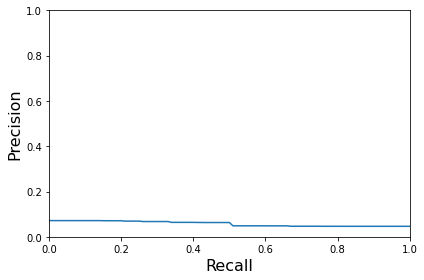

18.2339129447937


<Figure size 432x288 with 0 Axes>

In [59]:
label_len = len(label_dict_keys)
left_vectors = np.array(list(label_dict.keys())).reshape((label_len))
recalls = np.arange(0, 1.01, .01)
def get_n(prediction, label_vectors):
    indices = np.flip(np.argsort(prediction, axis=0)).reshape((label_len))
    #print(left_vectors[indices])
    e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
    cur = []
    total_ones = e.count(1)
    n = 0
    ones_seen = 0
    while ones_seen < total_ones:
        if e[n] == 1:
            ones_seen = ones_seen+1
        n = n+1
        cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
    new_cur = []
    for r in recalls:
        max_of_larger = max([i[0] for i in cur if i[1] >= r])
        new_cur.append(max_of_larger)
    return new_cur

def generate_prc():
    #print(label_len)
    left = np.vstack([label_dict[i] for i in label_dict_keys])
    num_tests = 500
    ns = []
    for row in pd.read_csv(directory_prefix+'datasets/items2.csv',sep=',', header = None).to_numpy()[:num_tests]:
        label, description=row[0], row[1]
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        if label_vectors == set():
            continue
        lstm_input_patent =  get_sentence_vector(description.lower(), num_words)
        #output = np.vstack([lstm_input_patent]*label_len)
        output = np.broadcast_to(lstm_input_patent, (label_len, lstm_input_patent.shape[0]))
        #print(output.shape, left.shape)
        prediction = model.predict({"input_1":output, "input_2":left}, verbose=0)
        #print(prediction.shape)
        n = get_n(prediction, label_vectors)
        ns.append(n)
        
    p = np.mean(np.array(ns), axis=0)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    #print(p) 
    plt.savefig('binary_prc1.eps', format='eps')
import time

start = time.time()
generate_prc()
end = time.time()
print(end - start)


Epoch 1/50
5442/5444 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9850 - mae: 0.0422
Epoch 00001: saving model to ..//checkpoints/hashingtrickcheckpoint.h5


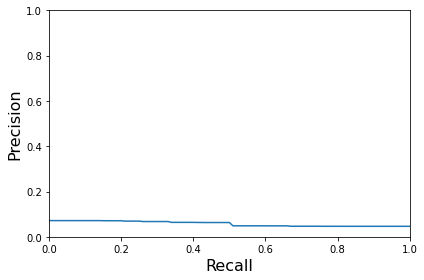

5444/5444 [==============================] - 37s 7ms/step - loss: 0.0860 - accuracy: 0.9850 - mae: 0.0422
Epoch 2/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9850 - mae: 0.0296
Epoch 00002: saving model to ..//checkpoints/hashingtrickcheckpoint.h5


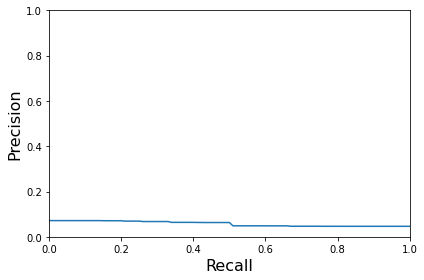

5444/5444 [==============================] - 37s 7ms/step - loss: 0.0778 - accuracy: 0.9850 - mae: 0.0296
Epoch 3/50
 907/5444 [===>..........................] - ETA: 15s - loss: 0.0757 - accuracy: 0.9855 - mae: 0.0288

In [ ]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=5444, callbacks=[cp_callback, prc_callback])

In [ ]:
print(occurences)

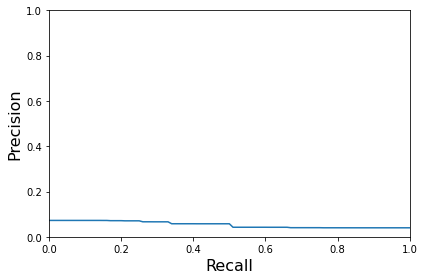

<Figure size 432x288 with 0 Axes>